In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, \
                    preconditioner_lib, structure_optimization_lib, cavi_lib

import paragami

import LinearResponseVariationalBayes.ExponentialFamilies as ef

In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [3]:
np.random.seed(53453)

# Draw data

In [4]:
n_obs = 40
n_loci = 50
n_pop = 4

In [5]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

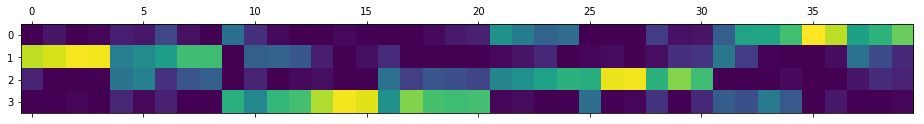

In [6]:
plt.matshow(true_ind_admix_propn.T)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_free_params = prior_params_paragami.flatten(prior_params_dict, free=True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
use_logitnormal_sticks = False

In [9]:
k_approx = 6

In [10]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [11]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx, use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 6, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (40, 5, 2) (lb=0.0, ub=inf)


## Initialize 

In [12]:
vb_params_dict = structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict, 
                                                        use_logitnormal_sticks)

In [13]:
# take a look at init 
if use_logitnormal_sticks: 
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_params_dict['ind_mix_stick_propn_mean'], 
                        vb_params_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)

else: 
    # take a look at init 
    ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
    e_stick_lengths = \
            modeling_lib.get_e_beta(ind_mix_stick_beta_params)
    e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])

In [14]:
if k_approx < 6: 
    # find minimizing permutation 
    # only feasible if k_approx is small, 
    # else my computer freezes
    perm = data_utils.find_min_perm(e_pop_freq, true_pop_allele_freq, axis = 1)
else: 
    perm = np.arange(k_approx)
    
e_pop_freq = e_pop_freq[:, perm]
e_ind_admix = e_ind_admix[:, perm]

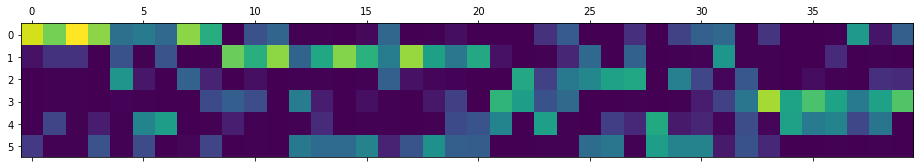

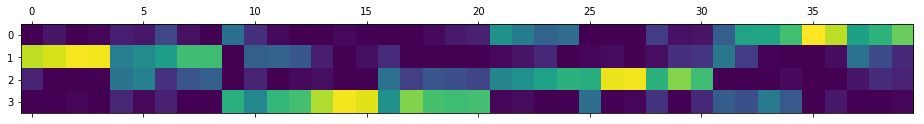

In [15]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

# Run CAVI

In [16]:
e_log_sticks, e_log_1m_sticks, \
    e_log_pop_freq, e_log_1m_pop_freq = \
        structure_model_lib.get_moments_from_vb_params_dict(g_obs, vb_params_dict, use_logitnormal_sticks)

In [17]:
e_z, stick_beta_params, pop_beta_params = \
    cavi_lib.run_cavi(g_obs, e_log_pop_freq, e_log_1m_pop_freq,
                e_log_sticks, e_log_1m_sticks,
                prior_params_dict, 
                max_iter = 2000, f_tol = 1e-2)

iteration [0]; kl:3952.608162
iteration [1]; kl:3392.455286
iteration [2]; kl:3303.661196
iteration [3]; kl:3277.030543
iteration [4]; kl:3264.05157
iteration [5]; kl:3255.748158
iteration [6]; kl:3249.762555
iteration [7]; kl:3245.140411
iteration [8]; kl:3241.393956
iteration [9]; kl:3238.246244
iteration [10]; kl:3235.529129
iteration [11]; kl:3233.134617
iteration [12]; kl:3230.989707
iteration [13]; kl:3229.04276
iteration [14]; kl:3227.255823
iteration [15]; kl:3225.600129
iteration [16]; kl:3224.053327
iteration [17]; kl:3222.597673
iteration [18]; kl:3221.218805
iteration [19]; kl:3219.90488
iteration [20]; kl:3218.645959
iteration [21]; kl:3217.433569
iteration [22]; kl:3216.260393
iteration [23]; kl:3215.120061
iteration [24]; kl:3214.007007
iteration [25]; kl:3212.916375
iteration [26]; kl:3211.843963
iteration [27]; kl:3210.786181
iteration [28]; kl:3209.740023
iteration [29]; kl:3208.703039
iteration [30]; kl:3207.673314
iteration [31]; kl:3206.649453
iteration [32]; kl:32

In [18]:
# check results after CAVI steps

In [19]:
# Set VB parameters
if use_logitnormal_sticks: 
    # convert beta params to logitnormal
    raise NotImplementedError()
else: 
    vb_params_dict['pop_freq_beta_params'] = pop_beta_params
    vb_params_dict['ind_mix_stick_beta_params'] = stick_beta_params

In [20]:
e_pop_allele_freq = modeling_lib.get_e_beta(pop_beta_params)

In [21]:
if k_approx < 6: 
    perm_best = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
else: 
    perm_best = perm

In [22]:
ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
e_stick_lengths = \
        modeling_lib.get_e_beta(ind_mix_stick_beta_params)
e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)[:, perm_best]

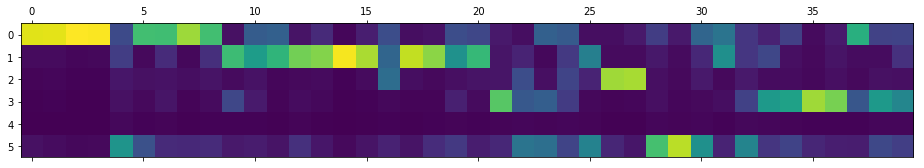

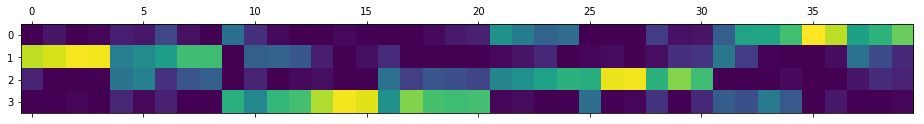

In [23]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

In [24]:
vb_params_dict_cavi = deepcopy(vb_params_dict)

# Check Hessian here?

Would have checked at the init, but its not even PSD

In [25]:
get_kl_from_vb_free_prior_free = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

In [26]:
vb_sens_cavi = \
        vittles.HyperparameterSensitivityLinearApproximation(
            objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, gh_loc, gh_weights, 
                                                                        use_logitnormal_sticks),
            opt_par_value = vb_params_paragami.flatten(vb_params_dict_cavi, free = True), 
            hyper_par_value = prior_free_params,
            validate_optimum=False,
            hessian_at_opt=None,
            cross_hess_at_opt=None,
            factorize_hessian=True,
            hyper_par_objective_fun=None,
            grad_tol=1e-8)

computing hessian ... 


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [27]:
vb_cavi_free_params = vb_params_paragami.flatten(vb_params_dict_cavi, free = True)
which_prior = np.array([1., 0., 0.])

hessian_der = str_opt_lib.check_hessian(vb_sens_cavi, which_prior)

NameError: name 'str_opt_lib' is not defined

In [ ]:
np.max(np.abs(hessian_der))

In [ ]:
# is this value meaningful? 
# lets compute the derivative using finite differences in the direction of the newton step

In [ ]:
# get newton step

# gradient wrt to vb free parameters
vb_grad = vb_sens_cavi._obj_fun_grad(vb_cavi_free_params, prior_free_params)

# get the direction of the next Newton step
step = - vb_sens_cavi.hess_solver.solve(vb_grad)
step_mag = np.linalg.norm(step, 2)

In [ ]:
# get new sensitivities at new newton step
h = 1e-4
vb_cavi_free_params2 = vb_cavi_free_params + step * h / step_mag

In [ ]:
vb_sens_cavi2 = \
        vittles.HyperparameterSensitivityLinearApproximation(
            objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, gh_loc, gh_weights, 
                                                                        use_logitnormal_sticks),
            opt_par_value = vb_cavi_free_params2, 
            hyper_par_value = prior_free_params,
            validate_optimum=False,
            hessian_at_opt=None,
            cross_hess_at_opt=None,
            factorize_hessian=True,
            hyper_par_objective_fun=None,
            grad_tol=1e-8)

In [ ]:
# finite differenes
sens_mat = np.dot(vb_sens_cavi._sens_mat, which_prior)
sens_mat2 = np.dot(vb_sens_cavi2._sens_mat, which_prior)

hessian_der_fd = (sens_mat2 - sens_mat) / h

In [ ]:
error = np.abs(hessian_der_fd - hessian_der / step_mag)
print(np.max(error))

# run a few Netwon steps

In [ ]:
# get loss as a function of vb parameters
get_free_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=structure_model_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_free_vb_params_loss_cached = \
    lambda x : get_free_vb_params_loss(g_obs, x, prior_params_dict, gh_loc, gh_weights, 
                                       use_logitnormal_sticks)

In [ ]:
init_vb_free_params = vb_params_paragami.flatten(vb_params_dict_cavi, free = True)

In [ ]:
get_free_vb_params_loss_cached(init_vb_free_params)

In [ ]:
vb_opt_free_params = opt_lib.optimize_full(get_free_vb_params_loss_cached, init_vb_free_params,
                    bfgs_max_iter = 0, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8,
                    init_hessian = None)

In [ ]:
vb_params_dict_newton = vb_params_paragami.fold(vb_opt_free_params, free = True)

In [ ]:
e_pop_allele_freq = modeling_lib.get_e_beta(vb_params_dict_newton['pop_freq_beta_params'])

In [ ]:
if k_approx < 6: 
    perm_best = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
else: 
    perm_best = perm

In [ ]:
ind_mix_stick_beta_params = vb_params_dict_newton['ind_mix_stick_beta_params']
e_stick_lengths = \
        modeling_lib.get_e_beta(ind_mix_stick_beta_params)
e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)[:, perm_best]

In [ ]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

# Lets take a look at the hessian

In [ ]:
vb_sens = \
        vittles.HyperparameterSensitivityLinearApproximation(
            objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, gh_loc, gh_weights, 
                                                                        use_logitnormal_sticks),
            opt_par_value = vb_opt_free_params,
            hyper_par_value = prior_free_params,
            validate_optimum=False,
            hessian_at_opt=None,
            cross_hess_at_opt=None,
            factorize_hessian=True,
            hyper_par_objective_fun=None,
            grad_tol=1e-8)

In [ ]:
hessian_dir = str_opt_lib.check_hessian(vb_sens, which_prior)

In [ ]:
np.max(np.abs(hessian_dir))